<a href="https://colab.research.google.com/github/flaviopradoaquino/TCC_MBA_USP_ESALQ/blob/main/TCC_USP_FaceBookPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalação e Importação das Bibliotecas**

In [ ]:
!pip install prophet
!pip install -q yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
import datetime
import plotly.express as px
###from prophet.forecaster import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from datetime import date, timedelta
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

# **Construção do Dataset**

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')

In [ ]:
from datetime import datetime 
dt_atual = date.today()
td = timedelta(1095)
dt_final = datetime(2023, 3, 3)

In [ ]:
###df = yf.download("BOVA11.SA", start='2018-01-01')['Close']
df = yf.download("BOVA11.SA", start=(dt_final-td))['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
### Importação do dados com data fixa
df = yf.download("BOVA11.SA", start="2020-03-03", end="2023-03-03")['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Date
2020-03-03    101.750000
2020-03-04    103.099998
2020-03-05     98.790001
2020-03-06     94.400002
2020-03-09     82.699997
                 ...    
2023-03-17     98.720001
2023-03-20     97.699997
2023-03-21     97.930000
2023-03-22     97.029999
2023-03-23     94.580002
Name: Close, Length: 761, dtype: float64

In [ ]:
df = df.reset_index()

In [ ]:
df

,Date,Close
0,2020-03-03,101.750000
1,2020-03-04,103.099998
2,2020-03-05,98.790001
3,2020-03-06,94.400002
4,2020-03-09,82.699997
...,...,...
756,2023-03-17,98.720001
757,2023-03-20,97.699997
758,2023-03-21,97.930000
759,2023-03-22,97.029999


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    761 non-null    datetime64[ns]
 1   Close   761 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [ ]:
df_bova_temp = df[['Date', 'Close']].rename(columns = {'Date': 'ds', 'Close': 'y'})

In [ ]:
df_bova_temp

,ds,y
0,2020-03-03,101.750000
1,2020-03-04,103.099998
2,2020-03-05,98.790001
3,2020-03-06,94.400002
4,2020-03-09,82.699997
...,...,...
756,2023-03-17,98.720001
757,2023-03-20,97.699997
758,2023-03-21,97.930000
759,2023-03-22,97.029999


In [ ]:
df_bova = pd.DataFrame({
  "ds": df_bova_temp['ds'].dt.date,
  "y":df_bova_temp['y']
})

In [ ]:
df_ts = df_bova
df_ts

,ds,y
0,2020-03-03,101.750000
1,2020-03-04,103.099998
2,2020-03-05,98.790001
3,2020-03-06,94.400002
4,2020-03-09,82.699997
...,...,...
756,2023-03-17,98.720001
757,2023-03-20,97.699997
758,2023-03-21,97.930000
759,2023-03-22,97.029999


In [ ]:
df_bova.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      761 non-null    object 
 1   y       761 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


# **Excluindo Outliers**

In [ ]:
dados = df_bova['y']
dados.describe()

count    761.000000
mean     104.024865
std       11.468565
min       61.139999
25%       98.360001
50%      105.830002
75%      111.510002
max      125.750000
Name: y, dtype: float64

In [ ]:
boxplot_bova = px.box(dados, y="y")
boxplot_bova.show()

In [ ]:
q1 = np.quantile(dados, .25, method="midpoint")
q2 = np.quantile(dados, .5, method="midpoint")
q3 = np.quantile(dados, .75, method="midpoint")
IIQ = q3 - q1

In [ ]:
### Limite inferior do boxplot
limite_inferior = q1 - 1.5 * IIQ
limite_inferior

78.6349983215332

In [ ]:
### Limite superior do boxplot
limite_superior = q3 + 1.5 * IIQ
limite_superior

131.23500442504883

In [ ]:
df_bova_lim_inf = df_bova[df_bova['y']>limite_inferior]
df_bova_clean = df_bova_lim_inf[df_bova_lim_inf['y']<limite_superior]
df_bova_clean

,ds,y
0,2020-03-03,101.750000
1,2020-03-04,103.099998
2,2020-03-05,98.790001
3,2020-03-06,94.400002
4,2020-03-09,82.699997
...,...,...
756,2023-03-17,98.720001
757,2023-03-20,97.699997
758,2023-03-21,97.930000
759,2023-03-22,97.029999


In [ ]:
df_bova = df_bova_clean
df_bova

,ds,y
0,2020-03-03,101.750000
1,2020-03-04,103.099998
2,2020-03-05,98.790001
3,2020-03-06,94.400002
4,2020-03-09,82.699997
...,...,...
756,2023-03-17,98.720001
757,2023-03-20,97.699997
758,2023-03-21,97.930000
759,2023-03-22,97.029999


## **Teste de Normalidade**

In [ ]:
import scipy.stats as stats

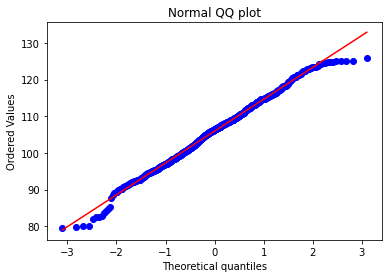

In [ ]:
stats.probplot(df_bova['y'], dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Teste Shapiro-Wilk

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [ ]:
e, p = stats.shapiro(df_bova['y'])
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9940751791000366
p-valor: 0.0066196005791425705


<ipython-input-190-5fa4aacb71a5>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='y', ylabel='Density'>

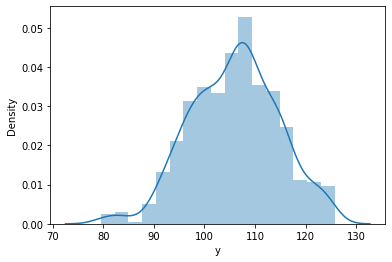

In [ ]:
import seaborn as sns
sns.distplot(df_bova['y'])

# **Construção do Modelo**

In [ ]:
### Hperparâmetros do modelo
md = Prophet(
             n_changepoints=20, 
             seasonality_mode='additive', 
             seasonality_prior_scale=10, 
             weekly_seasonality=False,
             daily_seasonality=False,
             interval_width=0.95
             )
### Adicionando feriados do Brasil
md.add_country_holidays(country_name='BR')
md.fit(df_bova)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpeutjhvrb/_pq1q1ql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeutjhvrb/x9acqmw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76471', 'data', 'file=/tmp/tmpeutjhvrb/_pq1q1ql.json', 'init=/tmp/tmpeutjhvrb/x9acqmw9.json', 'output', 'file=/tmp/tmpeutjhvrb/prophet_model7dcpxa5i/prophet_model-20230324010518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:05:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:05:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
tempo = md.make_future_dataframe(periods=90)
previsoes = md.predict(tempo)

In [ ]:
previsoes.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ano novo,Ano novo_lower,Ano novo_upper,Carnaval,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-03,91.641570,82.732304,98.302099,91.641570,91.641570,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.202545,-1.202545,-1.202545,0.0,0.0,0.0,90.439025
1,2020-03-04,91.668651,82.597512,97.802995,91.668651,91.668651,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.453184,-1.453184,-1.453184,0.0,0.0,0.0,90.215467
2,2020-03-05,91.695732,82.830810,98.039259,91.695732,91.695732,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.687745,-1.687745,-1.687745,0.0,0.0,0.0,90.007987
3,2020-03-06,91.722812,82.313030,97.286431,91.722812,91.722812,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.902841,-1.902841,-1.902841,0.0,0.0,0.0,89.819971
4,2020-03-09,91.804055,82.062656,96.318923,91.804055,91.804055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.399844,-2.399844,-2.399844,0.0,0.0,0.0,89.404211


In [ ]:
previsoes.head(3).T

,0,1,2
ds,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00
trend,91.64157,91.668651,91.695732
yhat_lower,82.732304,82.597512,82.83081
yhat_upper,98.302099,97.802995,98.039259
trend_lower,91.64157,91.668651,91.695732
trend_upper,91.64157,91.668651,91.695732
Ano novo,0.0,0.0,0.0
Ano novo_lower,0.0,0.0,0.0
Ano novo_upper,0.0,0.0,0.0
Carnaval,0.0,0.0,0.0


In [ ]:
### Conferindo a aderência dos feriados ao modelo
md.train_holiday_names

0                                        Ano novo
1                                      Tiradentes
2                         Dia Mundial do Trabalho
3                         Independência do Brasil
4                         Nossa Senhora Aparecida
5                                         Finados
6                        Proclamação da República
7                                           Natal
8                               Sexta-feira Santa
9                                          Páscoa
10                                 Corpus Christi
11    Quarta-feira de cinzas (Início da Quaresma)
12                                       Carnaval
dtype: object

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
plot_plotly(md, previsoes)

In [ ]:
plot_components_plotly(md, previsoes)

# **Avaliação do Modelo**

In [ ]:
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m-%d')
### Definição do intervalo de tempo
dt_atual = date.today()
td = timedelta(1095)

In [ ]:
### Importação dos dados do website da Yahoo Finance
df2 = yf.download("BOVA11.SA", start=(dt_atual-td))['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
### Contando o número de observações gerado
len(df2.index)

746

In [ ]:
### Definindo o dataset de avaliação a partir da linha 365
df_aval = df2[len(df2.index)-365:]
df_aval.shape

(365,)

In [ ]:
df2

Date
2020-03-24    67.400002
2020-03-25    71.730003
2020-03-26    74.570000
2020-03-27    70.220001
2020-03-30    71.970001
                ...    
2023-03-17    98.720001
2023-03-20    97.699997
2023-03-21    97.930000
2023-03-22    97.029999
2023-03-23    94.580002
Name: Close, Length: 746, dtype: float64

In [ ]:
### Gerando o boxblot pela variável com o valor de fechamento pregão do dia (Close)
boxplot_avaliacao = px.box(df_aval, y="Close")
boxplot_avaliacao.show()

In [ ]:
df2.shape

(746,)

In [ ]:
len(df2.index)-365

381

In [ ]:
teste = df2[len(df2.index)-365:]
teste.shape

(365,)

In [ ]:
teste.head()

Date
2021-10-06    106.370003
2021-10-07    106.419998
2021-10-08    108.389999
2021-10-11    107.750000
2021-10-13    109.239998
Name: Close, dtype: float64

In [ ]:
pred = md.make_future_dataframe(periods=0)
previsao = md.predict(pred)

In [ ]:
previsao = previsao['yhat'].tail(365)

In [ ]:
previsao

351    107.451273
352    107.447790
353    107.439276
354    107.362795
355    107.251939
          ...    
711    100.113595
712    100.603475
713    100.822941
714    101.064936
715    101.325445
Name: yhat, Length: 365, dtype: float64

In [ ]:
teste = teste.reset_index()
teste

,Date,Close
0,2021-10-06,106.370003
1,2021-10-07,106.419998
2,2021-10-08,108.389999
3,2021-10-11,107.750000
4,2021-10-13,109.239998
...,...,...
360,2023-03-17,98.720001
361,2023-03-20,97.699997
362,2023-03-21,97.930000
363,2023-03-22,97.029999


In [ ]:
teste = teste[['Close']]
teste

,Close
0,106.370003
1,106.419998
2,108.389999
3,107.750000
4,109.239998
...,...
360,98.720001
361,97.699997
362,97.930000
363,97.029999


In [ ]:
previsao = previsao.reset_index()
previsao = previsao[['yhat']]
previsao

,yhat
0,107.451273
1,107.447790
2,107.439276
3,107.362795
4,107.251939
...,...
360,100.113595
361,100.603475
362,100.822941
363,101.064936


In [ ]:
mean_absolute_error(teste, previsao)

2.9671132449094455